In [1]:
import tensorflow as tf
import numpy as np
import pickle as pkl
from sklearn.manifold import TSNE
from flip_gradient import flip_gradient
from utils import *
from timeit import default_timer as timer
import numpy as np
from keras import backend as K
from keras.datasets import mnist
from keras.layers import Conv2D,Dense,MaxPool2D,Flatten, Dropout
from keras.models import Sequential
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from keras_helper import NNWeightHelper
from snes import SNES
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import scipy.misc

/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# Process MNIST
mnist_train = (mnist.train.images > 0).reshape(55000, 28, 28, 1).astype(np.uint8) * 255
mnist_train = np.concatenate([mnist_train, mnist_train, mnist_train], 3)
mnist_test = (mnist.test.images > 0).reshape(10000, 28, 28, 1).astype(np.uint8) * 255
mnist_test = np.concatenate([mnist_test, mnist_test, mnist_test], 3)
mnist_valid = (mnist.validation.images > 0).reshape(mnist.validation.images.shape[0],28,28,1).astype(np.uint8)*255
mnist_valid= np.concatenate([mnist_valid,mnist_valid,mnist_valid],axis=3)


print(type(mnist_train[0]))

# Load MNIST-M
mnistm = pkl.load(open('mnistm_data.pkl', 'rb'))
mnistm_train = mnistm['train']
mnistm_test = mnistm['test']
mnistm_valid = mnistm['valid']

# Compute pixel mean for normalizing data
pixel_mean = np.vstack([mnist_train, mnistm_train]).mean((0, 1, 2))

# Create a mixed dataset for TSNE visualization
num_test = 500
combined_test_imgs = np.vstack([mnist_test[:num_test], mnistm_test[:num_test]])
combined_test_labels = np.vstack([mnist.test.labels[:num_test], mnist.test.labels[:num_test]])
combined_test_domain = np.vstack([np.tile([1., 0.], [num_test, 1]),
        np.tile([0., 1.], [num_test, 1])])


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
<type 'numpy.ndarray'>


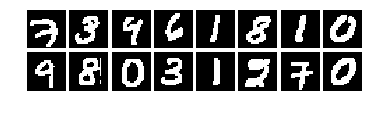

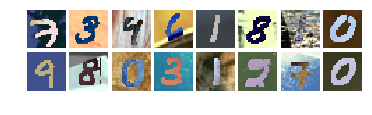

In [4]:
imshow_grid(mnist_train)
imshow_grid(mnistm_train)

In [5]:
mnist_train_labels = mnist.train.labels
mnist_test_labels = mnist.test.labels
mnist_valid_labels = mnist.validation.labels
print (len(mnist_train_labels), len(mnist_test_labels))

(55000, 10000)


In [6]:
img_rows, img_cols = 28, 28
num_classes = 10
input_shape = (img_rows, img_cols, 3)

In [44]:
x_train, y_train = mnist_train , mnist_train_labels
x_valid, y_valid = mnist_valid, mnist_valid_labels
Mx_train, My_train = mnistm_train , mnist_train_labels
Mx_valid, My_valid = mnistm_valid, mnist_valid_labels

In [68]:
model = Sequential()
model.add(Conv2D(32,kernel_size=(5,5),activation='relu',input_shape=input_shape))
model.add(MaxPool2D())
model.add((Conv2D(48,kernel_size=(3, 3), activation='relu')))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(20,activation='relu'))
model.compile(loss='mse',optimizer='adam')
model = model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 24, 24, 32)        2432      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 10, 10, 48)        13872     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 5, 5, 48)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1200)              0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 1200)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 20)                24020     
Total para

In [46]:
nnw = NNWeightHelper(model)
weights = nnw.get_weights()

In [47]:
SX=np.asarray(x_train)
SY=np.asarray(y_train)
SVX=np.asarray(x_valid)
SVY=np.asarray(y_valid)
input_shape=SX.shape[1:]

TX = np.asarray(Mx_train)
TY = np.asarray(My_train)
TVX = np.asarray(Mx_valid)
TVY = np.asarray(My_valid)

MX=np.concatenate((SX, TX), axis=0)
MY=np.concatenate((np.zeros(SX.shape[0]), np.ones(TX.shape[0])),axis=0)

MVX = np.concatenate((SVX, TVX),axis=0)
MVY = np.concatenate((np.zeros(SVX.shape[0]), np.ones(TVX.shape[0])),axis=0)

input_shape=SX.shape[1:]

In [48]:
def Train_classifier(x,y):
    x_features=model.predict(x)
    clf=RandomForestClassifier(n_estimators=18)
    clf=clf.fit(x_features, y)
    return clf

def Predict_from_clf(clf,x):
    x_features=model.predict(x)
    y=clf.predict(x_features)
    return y

def saveModel(filename):
    file=open(filename+'.json','w')
    file.write(model.to_json())
    model.save_weights(filename+'.h5')
    file.close()

def load_model(filename):
    file=open(filename+'.json')
    model=file.read()
    model=model_from_json(model)
    model.load_weight(filename+'.json')

def new_score_fun(label_accuracy,domain_accuray):
    return label_accuracy - (4*(np.square(domain_accuray-0.5)))


In [49]:
label_clf = RandomForestClassifier()
domain_clf = RandomForestClassifier()

In [50]:
RD_Indices = np.random.choice(a=list(range(MX.shape[0])),size=1024)
M_D_TX = MX[RD_Indices]
M_D_TY = MY[RD_Indices]

RS_Indices = np.random.choice(a=list(range(SX.shape[0])),size=1024)
S_TX = SX[RS_Indices]
S_TY = SY[RS_Indices]

RDV_indices = np.random.choice(a=list(range(MVX.shape[0])), size=1024)
M_D_VX = MVX[RDV_indices]
M_D_VY = MVY[RDV_indices]

SV_indices = np.random.choice(a=list((range(SVX.shape[0]))),size=1024)
validX = SVX[SV_indices]
validY = SVY[SV_indices]

In [67]:
label_clf = Train_classifier(SX,SY)
label_pred = Predict_from_clf(label_clf, validX)
label_accuracy = accuracy_score(validY,label_pred)
print ('label_accuracy',label_accuracy )

domain_clf = Train_classifier(M_D_TX, M_D_TY)
domain_pred = Predict_from_clf(domain_clf, M_D_VX)
domain_accuracy = accuracy_score(M_D_VY, domain_pred)
print ('domain_accuracy',domain_accuracy )

weight_modifier=NNWeightHelper(model)
weights=weight_modifier.get_weights()

print 'weights to evolve:',len(weights) 

('label_accuracy', 0.3076171875)
('domain_accuracy', 0.939453125)
weights to evolve: 182964


In [52]:
snes=SNES(weights,1,20)

In [54]:
logscore = []
for i in range(60):
    start = timer()
    new_weights=snes.ask()

    complied_score = []
    domain_accuracys = []
    label_accuracys = []

    for w in new_weights:
        RD_Indices = np.random.choice(a=list(range(MX.shape[0])),size=1024)
        M_D_TX = MX[RD_Indices]
        M_D_TY = MY[RD_Indices]

        RS_Indices = np.random.choice(a=list(range(SX.shape[0])),size=1024)
        S_TX = SX[RS_Indices]
        S_TY = SY[RS_Indices]

        RDV_indices = np.random.choice(a=list(range(MVX.shape[0])), size=1024)
        M_D_VX = MVX[RDV_indices]
        M_D_VY = MVY[RDV_indices]

        SV_indices = np.random.choice(a=list((range(SVX.shape[0]))),size=1024)
        validX = SVX[SV_indices]
        validY = SVY[SV_indices]
        weight_modifier.set_weights(w)

        label_clf=Train_classifier(S_TX,S_TY)
        label_predictions = Predict_from_clf(label_clf, validX)
        label_accuracy=accuracy_score(validY,label_predictions)
#         print ('label_accuracy',label_accuracy )

        domain_clf = Train_classifier(M_D_TX,M_D_TY)
        domain_predictions=Predict_from_clf(domain_clf,M_D_VX)
        domain_accuracy=accuracy_score(M_D_VY,domain_predictions)
#         print ('domain_accuracy',domain_accuracy )


        new_score = new_score_fun(label_accuracy, domain_accuracy)
        complied_score.append(new_score)
        domain_accuracys.append(domain_accuracy)
        label_accuracys.append(label_accuracy)

    snes.tell(new_weights,complied_score)
    max_index=np.argmax(complied_score)
    end = timer()
    print("It took", end - start, "seconds to complete generation")
    print("the fit model has label_accuracy: %0.3f and domain_accuracy:%0.3f and complied_score:%0.3f" 
          %(label_accuracys[max_index], domain_accuracys[max_index], complied_score[max_index]))
    
    logscore.append([complied_score[max_index],label_accuracys[max_index],domain_accuracys[max_index]])


('Step', 4, ':', -0.18674087524414062, 'best:', -0.18674087524414062, 20)
('It took', 21.010323762893677, 'seconds to complete generation')
the fit model has label_accuracy: 0.257 and domain_accuracy:0.833 and fitness_score:-0.187
('Step', 5, ':', -0.19321060180664062, 'best:', -0.18674087524414062, 20)
('It took', 20.44001007080078, 'seconds to complete generation')
the fit model has label_accuracy: 0.293 and domain_accuracy:0.849 and fitness_score:-0.193
('Step', 6, ':', -0.2868804931640625, 'best:', -0.18674087524414062, 20)
('It took', 20.697450876235962, 'seconds to complete generation')
the fit model has label_accuracy: 0.317 and domain_accuracy:0.889 and fitness_score:-0.287
('Step', 7, ':', -0.1671295166015625, 'best:', -0.1671295166015625, 20)
('It took', 20.77871084213257, 'seconds to complete generation')
the fit model has label_accuracy: 0.378 and domain_accuracy:0.869 and fitness_score:-0.167
('Step', 8, ':', -0.16141128540039062, 'best:', -0.16141128540039062, 20)
('It to

('Step', 40, ':', 0.20708847045898438, 'best:', 0.22661972045898438, 20)
('It took', 20.325758934020996, 'seconds to complete generation')
the fit model has label_accuracy: 0.237 and domain_accuracy:0.587 and fitness_score:0.207
('Step', 41, ':', 0.1748046875, 'best:', 0.22661972045898438, 20)
('It took', 20.31946611404419, 'seconds to complete generation')
the fit model has label_accuracy: 0.223 and domain_accuracy:0.609 and fitness_score:0.175
('Step', 42, ':', 0.1851654052734375, 'best:', 0.22661972045898438, 20)
('It took', 20.347121953964233, 'seconds to complete generation')
the fit model has label_accuracy: 0.196 and domain_accuracy:0.553 and fitness_score:0.185
('Step', 43, ':', 0.2070159912109375, 'best:', 0.22661972045898438, 20)
('It took', 20.83852505683899, 'seconds to complete generation')
the fit model has label_accuracy: 0.268 and domain_accuracy:0.623 and fitness_score:0.207
('Step', 44, ':', 0.1865081787109375, 'best:', 0.22661972045898438, 20)
('It took', 20.35717701

In [55]:
Save_Model('mnistmodeltestD_new')
import pandas as pd
scorelog = pd.DataFrame(logscore)
scorelog.to_csv('logscore.csv', header=None)

In [56]:
weight_modifier.set_weights(snes.center)

In [57]:
label_clf = Train_classifier(mnist_train,mnist_train_labels)
sourcePredictions = Predict_from_clf(label_clf, mnist_test)
sourceAccuray = accuracy_score(mnist_test_labels,sourcePredictions)
print  "label predicitions on MNIST %0.3f" % (sourceAccuray)

targetPredictions = Predict_from_clf(label_clf, mnistm_test)
targetAccuracy = accuracy_score(targetPredictions, mnist_test_labels)
print "label predicitons on MNISTM %0.3f" %(targetAccuracy)

label predicitions on MNIST 0.320
label predicitons on MNISTM 0.125


In [58]:
R_MT_INDEX = np.random.choice(a=list(range(MX.shape[0])), size=MY.shape[0])
TM_X = MX[R_MT_INDEX]
TM_Y = MY[R_MT_INDEX]

TEST_MX = np.concatenate([mnist_test, mnistm_test], axis=0)
TEST_MY = np.concatenate([np.zeros(mnist_test.shape[0]), np.ones(mnistm_test.shape[0])], axis=0)

In [59]:
domain_clf = Train_classifier(TM_X, TM_Y)
domain_pred = Predict_from_clf(domain_clf, TEST_MX)
domain_accuracy= accuracy_score(TEST_MY, domain_pred)
print("domain predicitions accuracy: %0.3f" %(domain_accuracy))

domain predicitions accuracy: 0.581


In [60]:
log = pd.read_csv('logscore.csv', header=None)

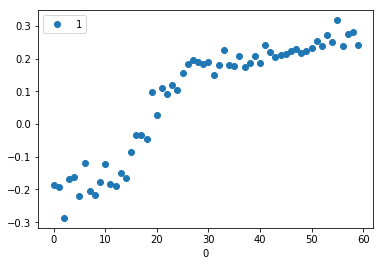

In [61]:
log.plot(x=0, y=1, style='o')